In [1]:
from dotenv import load_dotenv
from pathlib import Path
import sys
import os

# Walk up until we find the project root (folder with the .env)
current_path = Path().resolve()
for parent in [current_path] + list(current_path.parents):
    if (parent / ".env").exists():
        load_dotenv(parent / ".env")
        project_root = os.getenv("PROJECT_ROOT")
        print(project_root)
        sys.path.append(project_root)     
        break


%load_ext autoreload
%autoreload 2

/Users/emmanuel/Documents/belugas/save-the-belugas


In [ ]:
import pandas as pd
from preprocessing.spectrogram.spectrogram_generator import SpectrogramGenerator
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
DATA_DIRECTORY = "../data/"
wavs_folder_path = DATA_DIRECTORY + "Full_Dataset/Snippets_3s_wav/"


In [15]:
labels_df = pd.read_csv("../Call_Labels_All_Sites.csv")
sample = labels_df.sample(10)

In [17]:
def generate_spectrogram(file_path, spectrogram_generator, plot=False, title=None):
    start_time = time.time()
    audio, sr, _ = spectrogram_generator.load_audio(file_path)
    power_spect = spectrogram_generator.compute_mel_power_spect(audio)
    dB_spect = spectrogram_generator.power_to_db(power_spect)
    generation_time = time.time() - start_time
    if plot:
        
        print(f"{title} Spectrogram generation time: {generation_time:.4f} seconds \n shape: {dB_spect.shape}")
        spectrogram_generator.plot_spect(dB_spect, figsize=(6,2.9), title=f"{title}\n time: {generation_time:.4f} seconds \n shape: {dB_spect.shape}")
    return dB_spect, generation_time

In [34]:
# Create a dictionary of spectrogram generators with different configurations
spectrogram_generators = {
    "current": SpectrogramGenerator(
        n_fft=2048,
        hop_length=200,
        n_mels=64,
        fmin=200,
        sample_rate=192000
    ),
    # "less_mels": SpectrogramGenerator(
    #     n_mels=32,
    #     n_fft=2048,
    #     hop_length=200,
    #     fmin=200,
    #     sample_rate=192000
    # ),
    # "n_fft_1024": SpectrogramGenerator(
    #     n_mels=64,
    #     n_fft=1024,
    #     hop_length=200,
    #     fmin=200,
    #     sample_rate=192000
    # ),
    # "n_fft_512": SpectrogramGenerator(
    #     n_mels=64,
    #     n_fft=512,
    #     hop_length=200,
    #     fmin=200,
    #     sample_rate=192000
    # ),
    "n_fft_512_overlap_50": SpectrogramGenerator(
        n_mels=64,
        n_fft=512,
        hop_length=int(512*0.5),
        fmin=200,
        sample_rate=192000
    ),
    "n_fft_1024_overlap_50": SpectrogramGenerator(
        n_mels=64,
        n_fft=1024,
        hop_length=int(1024*0.5),
        fmin=200,
        sample_rate=192000
    ),
    "n_fft_2048_overlap_50": SpectrogramGenerator(
        n_mels=64,
        n_fft=2048,
        hop_length=int(2048*0.5),
        fmin=200,
        sample_rate=192000
    ),
    "n_fft_2048_overlap_10": SpectrogramGenerator(
        n_mels=64,
        n_fft=2048,
        hop_length=int(2048*0.9),
        fmin=200,
        sample_rate=192000
    ),
    "n_fft_2048_overlap_1": SpectrogramGenerator(
        n_mels=64,
        n_fft=2048,
        hop_length=int(2048*0.99),
        fmin=200,
        sample_rate=192000
    ),
    "n_fft_4096_overlap_50": SpectrogramGenerator(
        n_mels=64,
        n_fft=4096,
        hop_length=int(4096*0.5),
        fmin=200,
        sample_rate=192000
    ),
    "hp_2000": SpectrogramGenerator(
        n_mels=64,
        n_fft=2048,
        hop_length=2000,
        fmin=200,
        sample_rate=192000
    ),
    "hp_4000": SpectrogramGenerator(
        n_mels=64,
        n_fft=2048,
        hop_length=4000,
        fmin=200,
        sample_rate=192000
    ),
    # "n_fft_1048_hp_2000": SpectrogramGenerator(
    #     n_mels=64,
    #     n_fft=1048,
    #     hop_length=2000,
    #     fmin=200,
    #     sample_rate=192000
    # ),
    # "n_fft_1048_hop_length_2000_sample_rate_88100": SpectrogramGenerator(
    #     n_mels=64,
    #     n_fft=1048,
    #     hop_length=2000,
    #     fmin=200,
    #     sample_rate=88100
    # ),
    # "less_sample_rate": SpectrogramGenerator(
    #     n_mels=64,
    #     n_fft=2048,
    #     hop_length=200,
    #     fmin=200,
    #     sample_rate=80000
    # )
}

Running performance test on 20 audio files...

--- Performance Summary ---
current: 0.0539s (0.0% slower)
n_fft_512_overlap_50: 0.0191s (64.6% faster)
n_fft_1024_overlap_50: 0.0206s (61.8% faster)
n_fft_2048_overlap_50: 0.0213s (60.6% faster)
n_fft_2048_overlap_10: 0.0227s (57.9% faster)
n_fft_2048_overlap_1: 0.0169s (68.6% faster)
n_fft_4096_overlap_50: 0.0222s (58.9% faster)
hp_2000: 0.0137s (74.6% faster)
hp_4000: 0.0136s (74.8% faster)

Fastest configuration: hp_4000 (0.0136s)


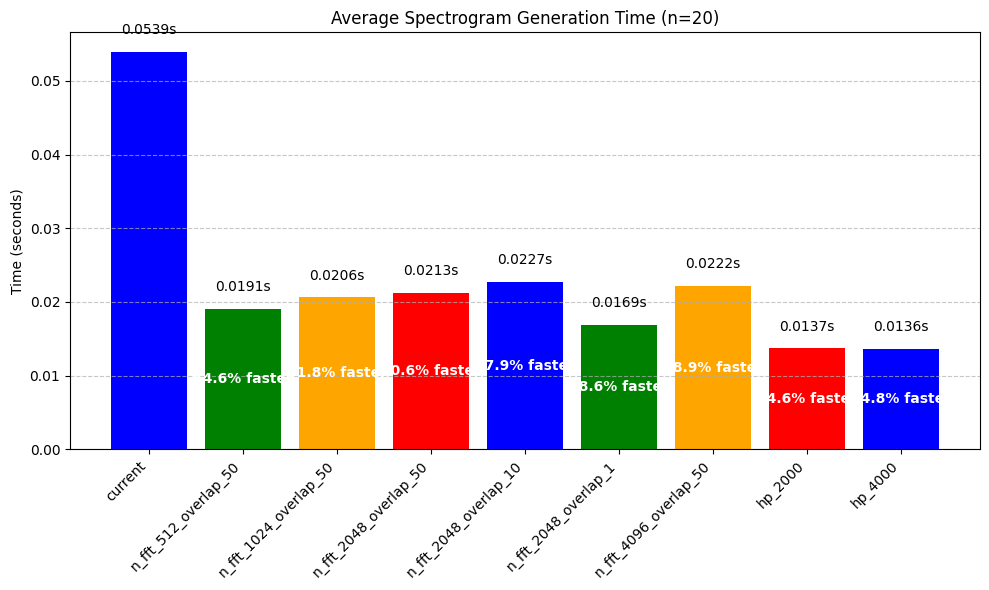

In [35]:
# Run performance test on a larger sample
sample_size = 20  # Increase this for more accurate results
performance_sample = labels_df.sample(sample_size)

# Initialize dictionary to store timing results
timing_results = {config: [] for config in spectrogram_generators.keys()}

print(f"Running performance test on {sample_size} audio files...")

for index, row in performance_sample.iterrows():
    file_path = wavs_folder_path + row["SnippetFilename"]
    
    # Run each configuration without plotting
    for config, generator in spectrogram_generators.items():
        _, proc_time = generate_spectrogram(file_path, generator, plot=False, title=config)
        timing_results[config].append(proc_time)

# Calculate average times
avg_times = {config: np.mean(times) for config, times in timing_results.items()}

# Plot results
plt.figure(figsize=(10, 6))
configs = list(avg_times.keys())
times = list(avg_times.values())

# Create bar chart
bars = plt.bar(configs, times, color=['blue', 'green', 'orange', 'red'])
plt.title(f'Average Spectrogram Generation Time (n={sample_size})')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Rotate x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')

# Add time values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.4f}s', ha='center', va='bottom')

# Calculate and display improvement percentages compared to current
baseline = avg_times["current"]
for i, config in enumerate(configs[1:], 1):
    improvement = (baseline - avg_times[config]) / baseline * 100
    plt.text(i, times[i]/2, f"{improvement:.1f}% faster" if improvement > 0 else f"{-improvement:.1f}% slower", 
             ha='center', va='center', color='white', fontweight='bold',)

plt.tight_layout()

# Print summary
print("\n--- Performance Summary ---")
for config, avg_time in avg_times.items():
    if config == "Current":
        print(f"{config}: {avg_time:.4f}s (baseline)")
    else:
        improvement = (baseline - avg_time) / baseline * 100
        status = "faster" if improvement > 0 else "slower"
        print(f"{config}: {avg_time:.4f}s ({abs(improvement):.1f}% {status})")

# Determine the fastest configuration
fastest_config = min(avg_times, key=avg_times.get)
print(f"\nFastest configuration: {fastest_config} ({avg_times[fastest_config]:.4f}s)")

In [ ]:
# Visualize spectrograms for a few examples
for index, row in sample.iterrows():
    file_path = wavs_folder_path + row["SnippetFilename"]
    
    # Generate and plot spectrograms for each configuration
    for config, generator in spectrogram_generators.items():
        generate_spectrogram(file_path, generator, plot=True, title=config)
    
    # Add a separator between different audio files
    print("\n" + "-"*50 + "\n")

<h1>Generating individual snippets or a single long one and the cutting it </h1>


In [27]:
long_audio = "/Users/emmanuel/Documents/belugas/long_recordings_test/low_170724163002.wav"


In [35]:
import librosa
def benchmark_spectrogram_approaches(file_path, spectrogram_generator, segment_length=1, num_segments=64, plot=True):
    """
    Compare two approaches:
    1. Generate individual spectrograms for each segment
    2. Generate one long spectrogram and then cut it into segments
    
    Args:
        file_path: Path to the audio file
        spectrogram_generator: SpectrogramGenerator instance
        segment_length: Length of each segment in seconds
        num_segments: Number of segments to process
        plot: Whether to plot example spectrograms
    
    Returns:
        Dictionary with timing results
    """
    sr = spectrogram_generator.sample_rate
    samples_per_segment = int(segment_length * sr)
    
    # Load the full audio file
    print(f"Loading audio file: {file_path}")
    full_audio, sr_actual = librosa.load(file_path, sr=sr, mono=True)
    print(f"Audio loaded: {len(full_audio)/sr_actual:.2f} seconds")
    
    # Ensure we have enough audio for the test
    if len(full_audio) < samples_per_segment * num_segments:
        num_segments = len(full_audio) // samples_per_segment
        print(f"Warning: Audio file too short. Reducing to {num_segments} segments.")
    
    # Approach 1: Individual segments
    start_time = time.time()
    individual_spectrograms = []
    
    for i in range(num_segments):
        segment = full_audio[i * samples_per_segment:(i + 1) * samples_per_segment]
        power_spect = spectrogram_generator.compute_mel_power_spect(segment)
        db_spect = spectrogram_generator.power_to_db(power_spect)
        individual_spectrograms.append(db_spect)
    
    individual_time = time.time() - start_time
    
    # Approach 2: One long spectrogram
    start_time = time.time()
    long_segment = full_audio[:samples_per_segment * num_segments]
    long_power_spect = spectrogram_generator.compute_mel_power_spect(long_segment)
    long_db_spect = spectrogram_generator.power_to_db(long_power_spect)
    
    # Calculate the number of time bins per segment
    time_bins_per_segment = int(segment_length * sr / spectrogram_generator.hop_length)
    
    # Cut the long spectrogram into segments
    cut_spectrograms = []
    for i in range(num_segments):
        start_bin = i * time_bins_per_segment
        end_bin = (i + 1) * time_bins_per_segment
        cut_spectrograms.append(long_db_spect[:, start_bin:end_bin])
    
    batch_time = time.time() - start_time
    
    results = {
        "individual_time": individual_time,
        "batch_time": batch_time,
        "improvement_percent": (individual_time - batch_time) / individual_time * 100,
        "num_segments": num_segments,
        "segment_length": segment_length
    }
    
    if plot:
        
        spectrogram_generator.plot_spect(individual_spectrograms[0], title=f"Individual spectrogram approach\nSegment 0 of {num_segments}, shape: {individual_spectrograms[0].shape}")
        
        spectrogram_generator.plot_spect(cut_spectrograms[0], title=f"Cut from long spectrogram approach\nSegment 0 of {num_segments}, shape: {cut_spectrograms[0].shape}")
    
    return results


Running benchmark for configuration: current
Loading audio file: /Users/emmanuel/Documents/belugas/long_recordings_test/low_170724163002.wav
Audio loaded: 599.84 seconds


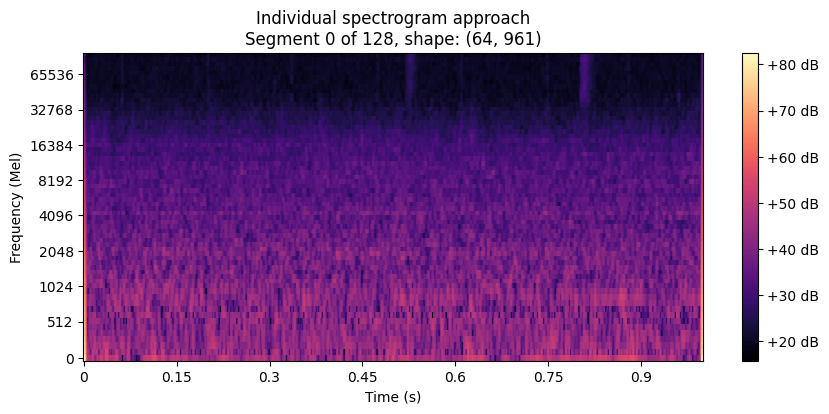

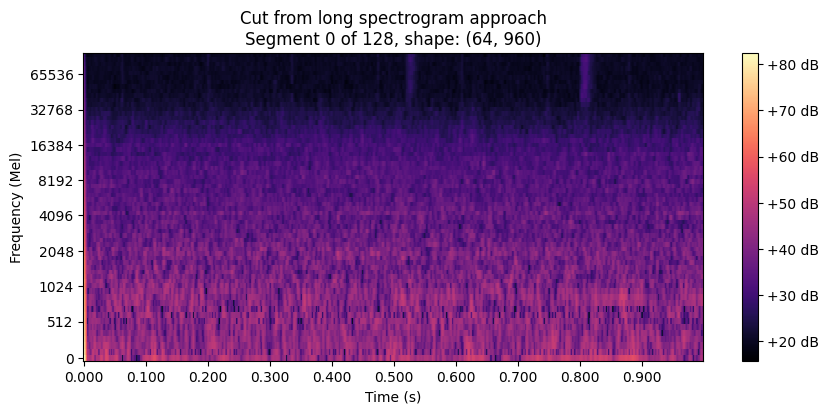

Individual segments: 2.0798s
Batch processing: 1.3449s
Improvement: 35.34%

Running benchmark for configuration: n_fft_1024
Loading audio file: /Users/emmanuel/Documents/belugas/long_recordings_test/low_170724163002.wav
Audio loaded: 599.84 seconds


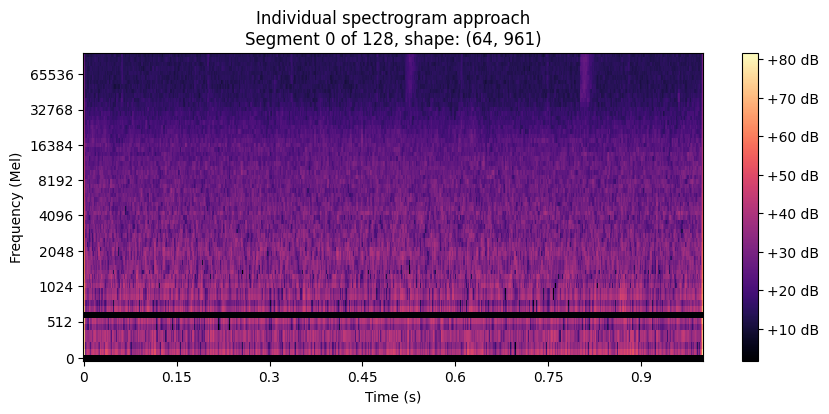

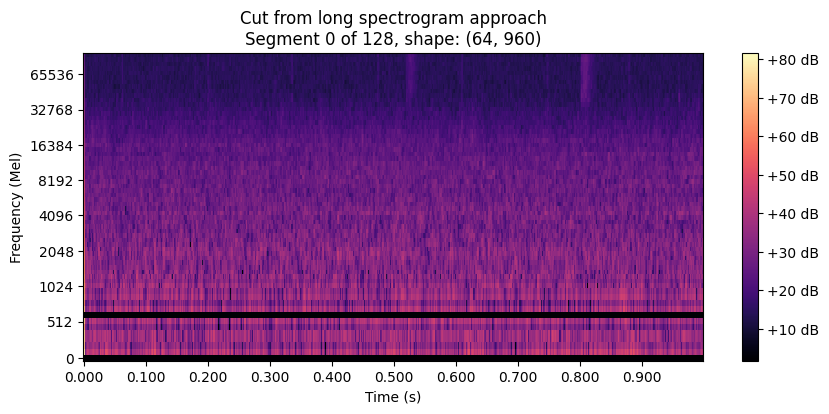

Individual segments: 1.1865s
Batch processing: 0.6509s
Improvement: 45.14%

Running benchmark for configuration: n_fft_512
Loading audio file: /Users/emmanuel/Documents/belugas/long_recordings_test/low_170724163002.wav
Audio loaded: 599.84 seconds


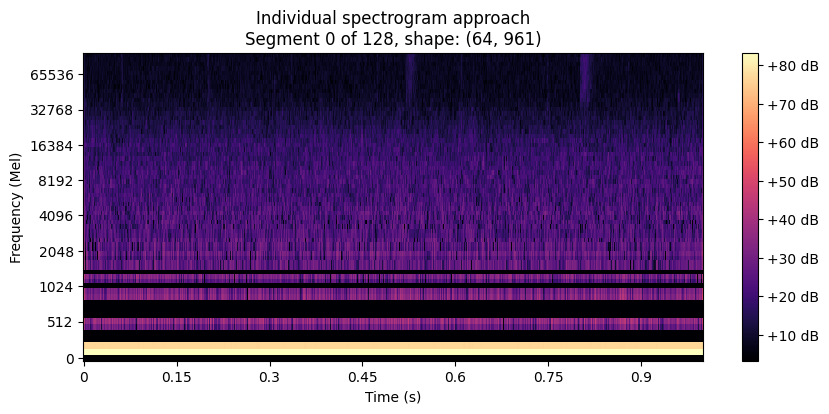

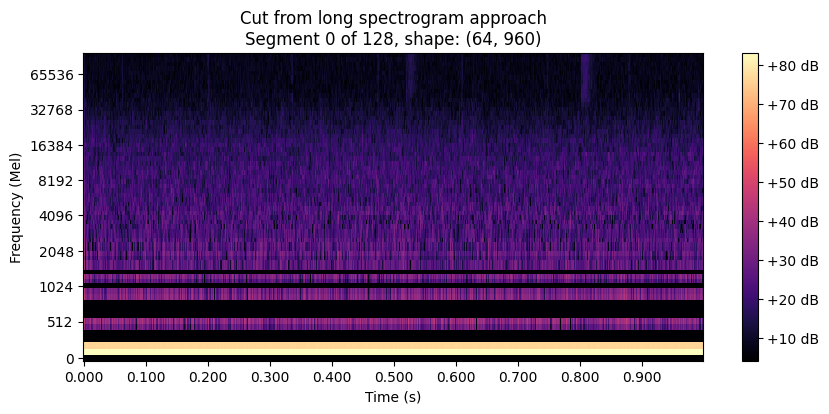

Individual segments: 0.6791s
Batch processing: 0.3761s
Improvement: 44.62%

Running benchmark for configuration: hp_1000
Loading audio file: /Users/emmanuel/Documents/belugas/long_recordings_test/low_170724163002.wav
Audio loaded: 599.84 seconds


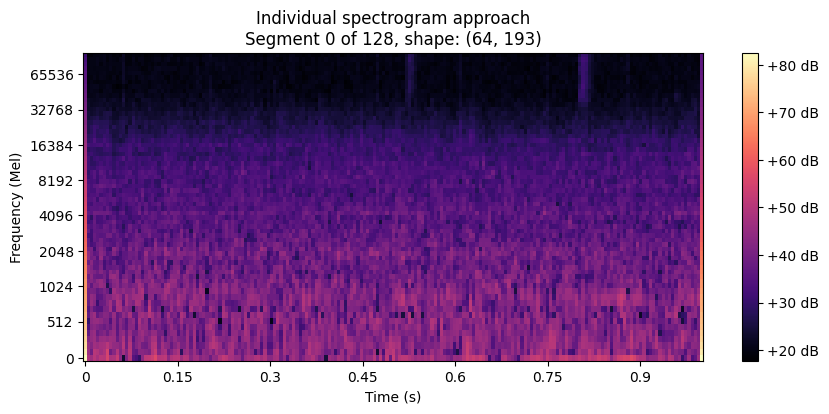

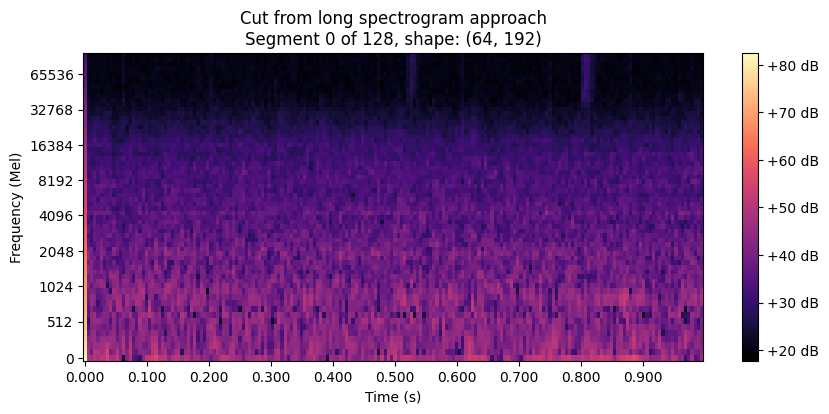

Individual segments: 0.5977s
Batch processing: 0.2914s
Improvement: 51.26%

Running benchmark for configuration: hp_2000
Loading audio file: /Users/emmanuel/Documents/belugas/long_recordings_test/low_170724163002.wav
Audio loaded: 599.84 seconds


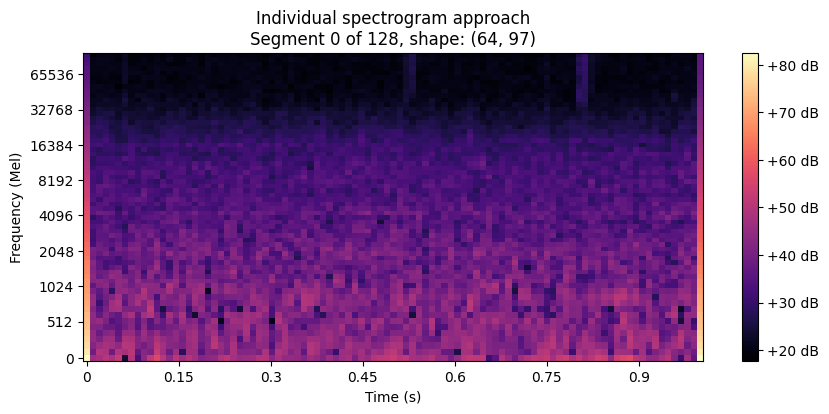

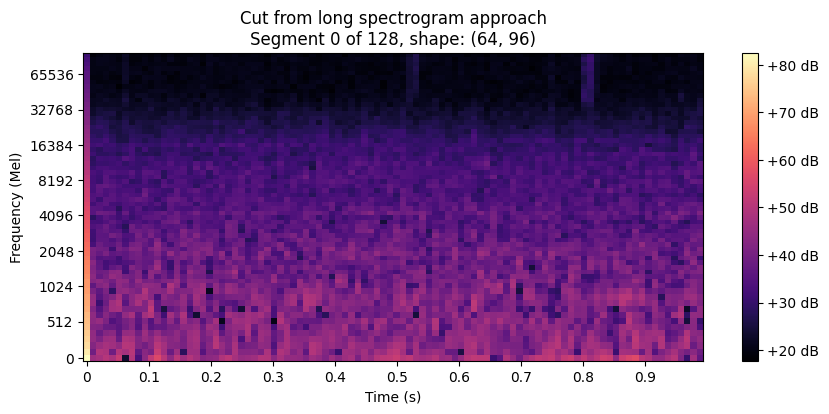

Individual segments: 0.3777s
Batch processing: 0.1512s
Improvement: 59.97%

Running benchmark for configuration: hp_4000
Loading audio file: /Users/emmanuel/Documents/belugas/long_recordings_test/low_170724163002.wav
Audio loaded: 599.84 seconds


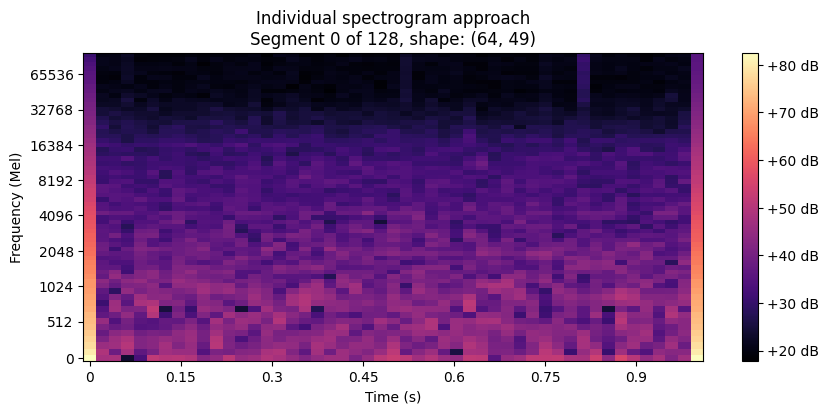

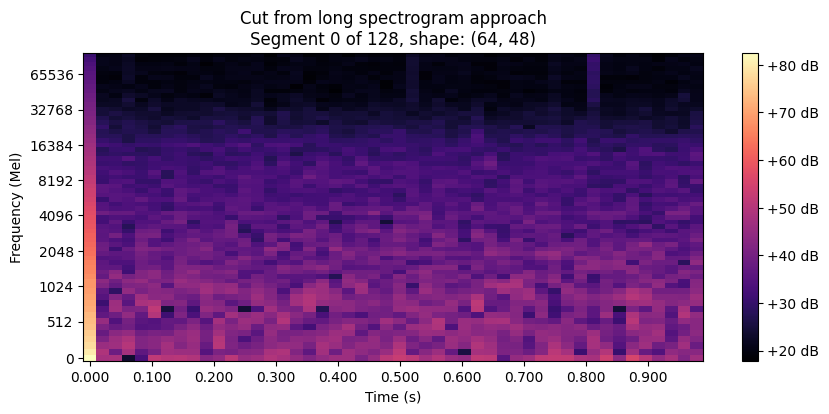

Individual segments: 0.2336s
Batch processing: 0.0768s
Improvement: 67.14%

Running benchmark for configuration: n_fft_1048_hp_2000
Loading audio file: /Users/emmanuel/Documents/belugas/long_recordings_test/low_170724163002.wav
Audio loaded: 599.84 seconds


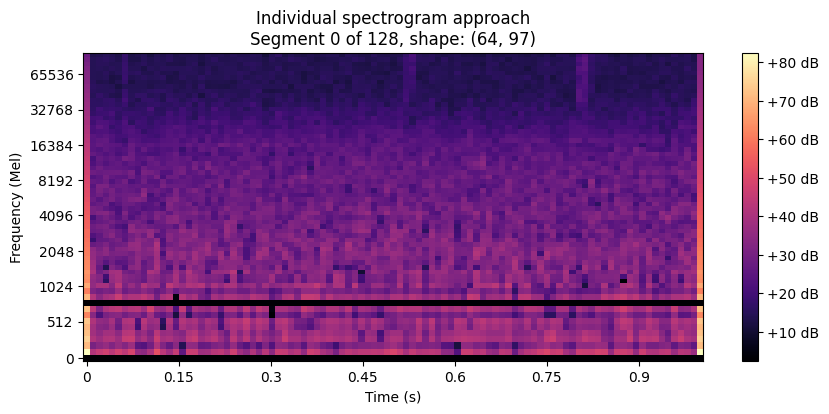

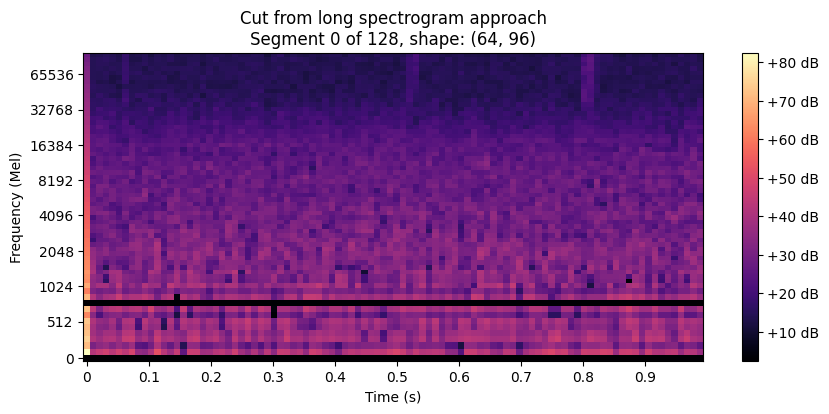

Individual segments: 0.5645s
Batch processing: 0.2515s
Improvement: 55.44%


In [37]:



segment_length = 1  # seconds
num_segments = 128   # number of segments to process

benchmark_results = {}

for config, generator in spectrogram_generators.items():
    print(f"\nRunning benchmark for configuration: {config}")
    result = benchmark_spectrogram_approaches(
        long_audio, 
        generator, 
        segment_length=segment_length,
        num_segments=num_segments,
        plot=True
    )
    benchmark_results[config] = result
    
    print(f"Individual segments: {result['individual_time']:.4f}s")
    print(f"Batch processing: {result['batch_time']:.4f}s")
    print(f"Improvement: {result['improvement_percent']:.2f}%")


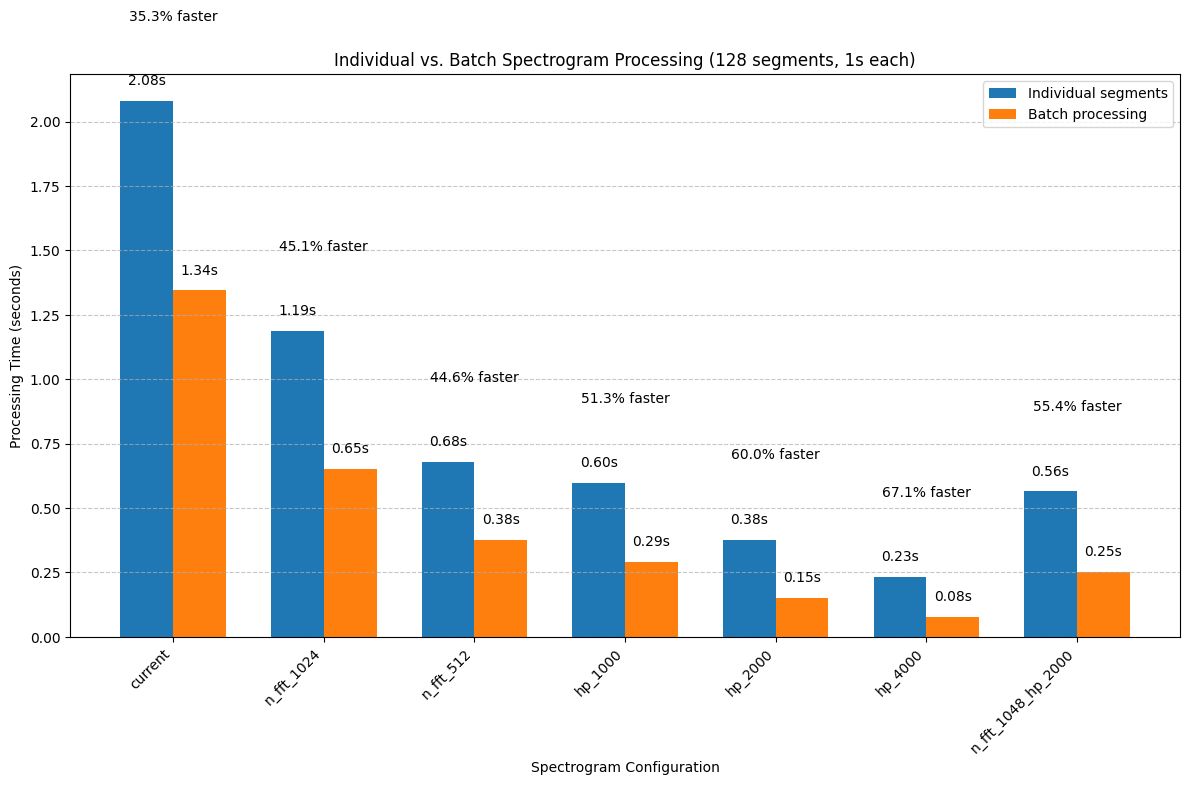

,Configuration,Individual Time (s),Batch Time (s),Improvement (%)
5,hp_4000,0.233593,0.076755,67.141545
4,hp_2000,0.377683,0.151181,59.971543
6,n_fft_1048_hp_2000,0.564469,0.251537,55.438332
3,hp_1000,0.597719,0.291358,51.255018
1,n_fft_1024,1.186526,0.650924,45.140356
2,n_fft_512,0.679135,0.376071,44.624957
0,current,2.079767,1.344854,35.336308


In [38]:

plt.figure(figsize=(12, 8))

configs = list(benchmark_results.keys())
individual_times = [benchmark_results[config]['individual_time'] for config in configs]
batch_times = [benchmark_results[config]['batch_time'] for config in configs]

x = np.arange(len(configs))
width = 0.35

bars1 = plt.bar(x - width/2, individual_times, width, label='Individual segments')
bars2 = plt.bar(x + width/2, batch_times, width, label='Batch processing')

plt.xlabel('Spectrogram Configuration')
plt.ylabel('Processing Time (seconds)')
plt.title(f'Individual vs. Batch Spectrogram Processing ({num_segments} segments, {segment_length}s each)')
plt.xticks(x, configs, rotation=45, ha='right')
plt.legend()

# Add time values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.2f}s', ha='center', va='bottom')

# Add improvement percentages
for i, config in enumerate(configs):
    improvement = benchmark_results[config]['improvement_percent']
    plt.text(i, max(individual_times[i], batch_times[i]) + 0.3, 
             f"{improvement:.1f}% faster", ha='center', va='bottom')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Create a summary table
summary_data = {
    'Configuration': configs,
    'Individual Time (s)': individual_times,
    'Batch Time (s)': batch_times,
    'Improvement (%)': [benchmark_results[config]['improvement_percent'] for config in configs]
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Improvement (%)', ascending=False)
summary_df